In [1]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data
X_train = pd.read_csv("Sonar/X_train.csv") 
X_test = pd.read_csv("Sonar/X_test.csv")
y_train = pd.read_csv("Sonar/y_train.csv")
y_test = pd.read_csv("Sonar/y_test.csv")

# Delete columns containing the original indices
del X_train["Unnamed: 0"] 
del X_test["Unnamed: 0"] 
del y_train["Unnamed: 0"] 
del y_test["Unnamed: 0"] 

# Rename columns
y_train.columns = ["Label"]
y_test.columns = ["Label"]

# Inspect data
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60
0,0.0968,0.0821,0.0629,0.0608,0.0617,0.1207,0.0944,0.4223,0.5744,0.5025,...,0.0206,0.0073,0.0081,0.0303,0.0190,0.0212,0.0126,0.0201,0.0210,0.0041
1,0.0311,0.0491,0.0692,0.0831,0.0079,0.0200,0.0981,0.1016,0.2025,0.0767,...,0.0089,0.0087,0.0032,0.0130,0.0188,0.0101,0.0229,0.0182,0.0046,0.0038
2,0.0201,0.0026,0.0138,0.0062,0.0133,0.0151,0.0541,0.0210,0.0505,0.1097,...,0.0072,0.0108,0.0070,0.0063,0.0030,0.0011,0.0007,0.0024,0.0057,0.0044
3,0.0180,0.0444,0.0476,0.0698,0.1615,0.0887,0.0596,0.1071,0.3175,0.2918,...,0.0122,0.0122,0.0114,0.0098,0.0027,0.0025,0.0026,0.0050,0.0073,0.0022
4,0.0094,0.0333,0.0306,0.0376,0.1296,0.1795,0.1909,0.1692,0.1870,0.1725,...,0.0216,0.0153,0.0112,0.0241,0.0164,0.0055,0.0078,0.0055,0.0091,0.0067


In [3]:
# Change to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train["Label"])
y_test = np.array(y_test["Label"])

In [4]:
# Scale the design matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train) # Must not use test data to determine the scaling
X_test = scaler.transform(X_test) 

In [5]:
# Implement logistic regression without regularisation
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty="none", max_iter=1000, solver='lbfgs')
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# Calculate empirical risk using zero-one loss
from sklearn.metrics import zero_one_loss

zero_one_train = zero_one_loss(y_train, log.predict(X_train), normalize=True) # On training data
zero_one_test = zero_one_loss(y_test, log.predict(X_test), normalize=True) # On test data
print(f"The empirical risk on the training data is {zero_one_train:.4f}")
print(f"The empirical risk on the test data is {zero_one_test:.4f}")

The empirical risk on the training data is 0.0000
The empirical risk on the test data is 0.2857


In [7]:
# Calculate empirical risk using logistic loss
from sklearn.metrics import log_loss

logistic_train = log_loss(y_train, log.predict_proba(X_train), normalize=True) # On training data
logistic_test = log_loss(y_test, log.predict_proba(X_test), normalize=True) # On test data
print(f"The empirical risk on the training data is {logistic_train:.4f}")
print(f"The empirical risk on the test data is {logistic_test:.4f}")

The empirical risk on the training data is 0.0000
The empirical risk on the test data is 8.7866


In [8]:
# Implement logistic regression with regularisation

# Use different regularisation strengths
lambda_list = np.linspace(0.001, 0.25, 100)
np.insert(lambda_list, 0, 10^-20) # Add in lambda = 0 (but not exactly zero, or C will be undefined)

# Create arrays to store results
risk_train_ridge = []
risk_test_ridge = []
risk_train_lasso = []
risk_test_lasso = []

n = len(X_train)

# Iterate through lambda values
for l in lambda_list:
    
    # Ridge penalty
    log_ridge = LogisticRegression(penalty="l2", C=1/(2*l*n), max_iter=1000)
    log_ridge.fit(X_train, y_train)
    risk_train_ridge.append(log_loss(y_train, log_ridge.predict_proba(X_train), normalize=True))
    risk_test_ridge.append(log_loss(y_test, log_ridge.predict_proba(X_test), normalize=True))
    
    # Lasso penalty
    log_lasso = LogisticRegression(penalty="l1", C=1/(l*n), solver="saga", max_iter=5000) # saga supports lasso
    log_lasso.fit(X_train, y_train)
    risk_train_lasso.append(log_loss(y_train, log_lasso.predict_proba(X_train), normalize=True))
    risk_test_lasso.append(log_loss(y_test, log_lasso.predict_proba(X_test), normalize=True))

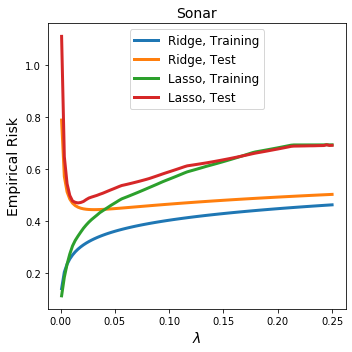

In [9]:
# Plot graphs to visualise effect of lambda on empirical risk
plt.figure(figsize=(5, 5))
plt.plot(lambda_list, risk_train_ridge, label="Ridge, Training", lw=3)
plt.plot(lambda_list, risk_test_ridge, label="Ridge, Test", lw=3)
plt.plot(lambda_list, risk_train_lasso, label="Lasso, Training", lw=3)
plt.plot(lambda_list, risk_test_lasso, label="Lasso, Test", lw=3)
plt.xlabel("$\lambda$", fontsize=14)
plt.ylabel("Empirical Risk", fontsize=14)
plt.legend(fontsize=12, loc="upper center")
plt.title("Sonar", fontsize=14)
plt.tight_layout()
plt.savefig("sonar-logistic.png")
plt.show()

In [10]:
# Find best classifier (ridge penalty if using test data)
index = np.argmin(risk_test_ridge)
best_lambda = lambda_list[index]
best_risk = risk_test_ridge[index]
print(f"The best model is ridge penalty with lambda equals {best_lambda:.4f}. \
The empirical risk is {best_risk:.4f} in this case.")

The best model is ridge penalty with lambda equals 0.0312. The empirical risk is 0.4434 in this case.


In [11]:
# Calculate zero-one loss for the model which performed highest on the test data
log_best = LogisticRegression(penalty="l2", C=1/(2*best_lambda*n), max_iter=1000)
log_best.fit(X_train, y_train)
zero_one_train = zero_one_loss(y_train, log_best.predict(X_train), normalize=True)
zero_one_test = zero_one_loss(y_test, log_best.predict(X_test), normalize=True)

# Report results 
print(f"The training risk for the highest performing model was {zero_one_train:.4f}")
print(f"The test risk for the highest performing model was {zero_one_test:.4f}")

The training risk for the highest performing model was 0.1265
The test risk for the highest performing model was 0.1905


In [12]:
# Classification method 2 – neural network
from sklearn.neural_network import MLPClassifier

# The default NN in sklearn uses a single hidden layer with 100 neurons, ReLU and L2 regularisation
default_nn = MLPClassifier(max_iter=1000, random_state=2083836) 
default_nn.fit(X_train, y_train)

# Calculate empirical risk using zero-one loss
zero_one_train = zero_one_loss(y_train, default_nn.predict(X_train), normalize=True)
zero_one_test = zero_one_loss(y_test, default_nn.predict(X_test), normalize=True)

# Report results
print("DEFAULT NEURAL NETWORK:\n")
print(f"The training risk was: {zero_one_train:.4f}")
print(f"The test risk was: {zero_one_test:.4f}")

DEFAULT NEURAL NETWORK:

The training risk was: 0.0000
The test risk was: 0.2381


In [13]:
# Tune hyperparameters using 10-fold cross-validation
# GridSearchCV uses accuracy (= 1 - zero-one loss)
# Due to long runtimes, only a few configurations will be investigated
from sklearn.model_selection import GridSearchCV

params = {"activation": ["logistic", "relu"], 
          "alpha": [0.01, 0.1, 1, 10, 100],
          "hidden_layer_sizes": [(100,), (100, 100)]}
clf = GridSearchCV(estimator=MLPClassifier(max_iter=5000, random_state=2083836), param_grid=params, cv=10)
clf.fit(X_train, y_train)
print("The best parameters are:\n")
print(clf.best_params_)

The best parameters are:

{'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (100, 100)}


In [14]:
# Fit tuned neural network
nn = MLPClassifier(activation='relu', alpha=10, hidden_layer_sizes=(100,), max_iter=5000, random_state=2083836) 
nn.fit(X_train, y_train)

# Calculate empirical risk using zero-one loss
zero_one_train = zero_one_loss(y_train, nn.predict(X_train), normalize=True)
zero_one_test = zero_one_loss(y_test, nn.predict(X_test), normalize=True)

# Report results
print("TUNED NEURAL NETWORK:\n")
print(f"The training risk was: {zero_one_train:.4f}")
print(f"The test risk was: {zero_one_test:.4f}")

# We will use the default hyperparameters because the results are worse after optimisation

TUNED NEURAL NETWORK:

The training risk was: 0.0120
The test risk was: 0.2619
